In [1]:
import cv2
import numpy as np
from collections import defaultdict

SAMPLE_COUNT = 20
DISPLAY_SCALE = 0.5

full_img = cv2.imread(r"Run1024/frame_0000.png", cv2.IMREAD_UNCHANGED)
sub_img = cv2.imread(r"Arm L.png", cv2.IMREAD_UNCHANGED)

if full_img is None or sub_img is None:
    raise ValueError("Could not load images. Check file paths.")


In [2]:
def binarize_alpha(img, threshold=128):
    """
    Converts the alpha channel of an image to binary:
    - Pixels with alpha >= threshold become 255 (opaque)
    - Pixels with alpha < threshold become 0 (transparent)
    
    Returns a new 4-channel image with binary alpha.
    """
    if img.shape[2] != 4:
        raise ValueError("Image must have an alpha channel (4 channels).")
    
    rgb = img[:, :, :3]
    alpha = img[:, :, 3]
    
    alpha_binary = np.where(alpha >= threshold, 255, 0).astype(np.uint8)
    return np.dstack((rgb, alpha_binary))

full_img = binarize_alpha(full_img)
sub_img = binarize_alpha(sub_img)

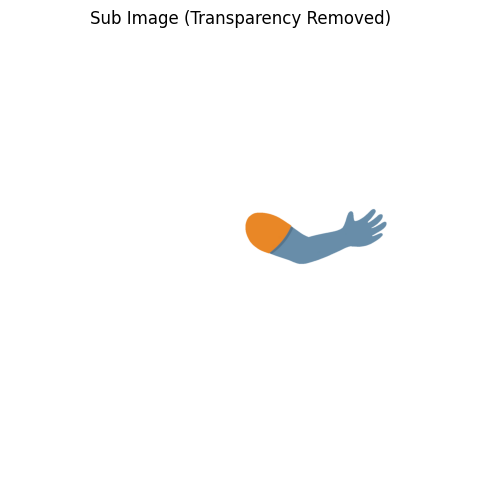

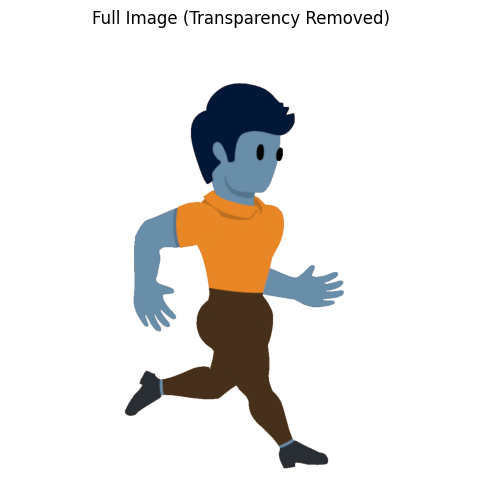

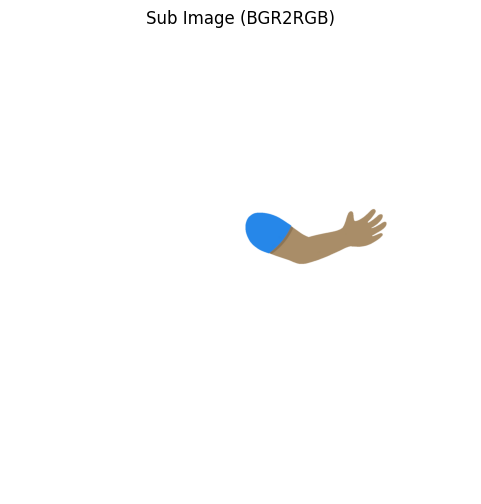

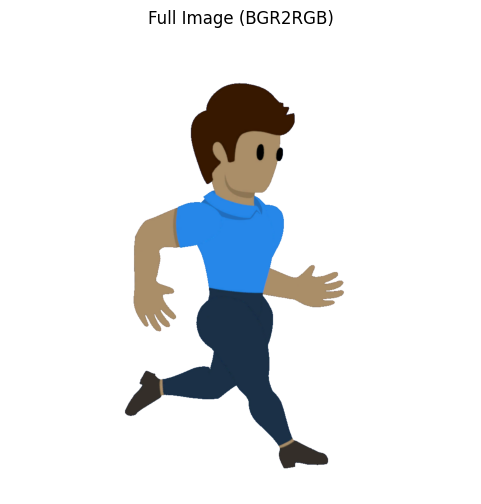

In [3]:
import matplotlib.pyplot as plt

def remove_transparency(img, bg_color=(255, 255, 255)):
    if img.shape[2] == 4:
        alpha = img[:, :, 3] / 255.0
        bg = np.ones_like(img[:, :, :3], dtype=np.uint8) * np.array(bg_color, dtype=np.uint8)
        img_rgb = img[:, :, :3]
        out_img = (img_rgb * alpha[..., None] + bg * (1 - alpha[..., None])).astype(np.uint8)
        return out_img
    return img  # Already 3-channel

sub_img_bgr = remove_transparency(sub_img)
full_img_bgr = remove_transparency(full_img)

def convert_bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def show_image(img, title="Image"):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

show_image(sub_img_bgr, title="Sub Image (Transparency Removed)")
show_image(full_img_bgr, title="Full Image (Transparency Removed)")

sub_img_rgb = convert_bgr_to_rgb(sub_img_bgr)
full_img_rgb = convert_bgr_to_rgb(full_img_bgr) 

show_image(sub_img_rgb, title="Sub Image (BGR2RGB)")
show_image(full_img_rgb, title="Full Image (BGR2RGB)")


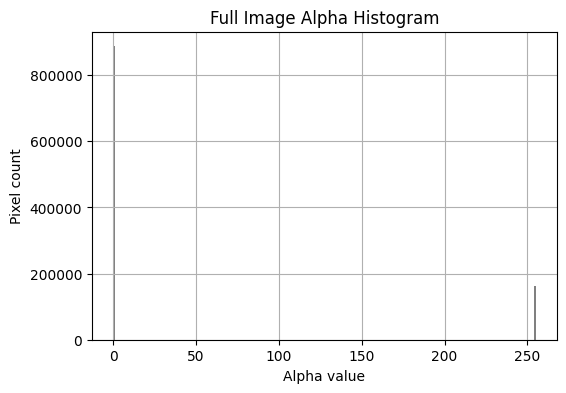

Image does not have an alpha channel.


In [4]:
def plot_alpha_histogram(img, title="Alpha Histogram"):
    if img.shape[2] == 4:
        alpha = img[:, :, 3]
        plt.figure(figsize=(6, 4))
        plt.hist(alpha.ravel(), bins=256, range=(0, 255), color='gray')
        plt.title(title)
        plt.xlabel("Alpha value")
        plt.ylabel("Pixel count")
        plt.grid(True)
        plt.show()
    else:
        print("Image does not have an alpha channel.")

plot_alpha_histogram(full_img, title="Full Image Alpha Histogram")
plot_alpha_histogram(full_img_rgb, title="Full Image RGB Alpha Histogram")

In [5]:
sub_channels = cv2.split(sub_img_rgb)
full_channels = cv2.split(full_img_rgb)

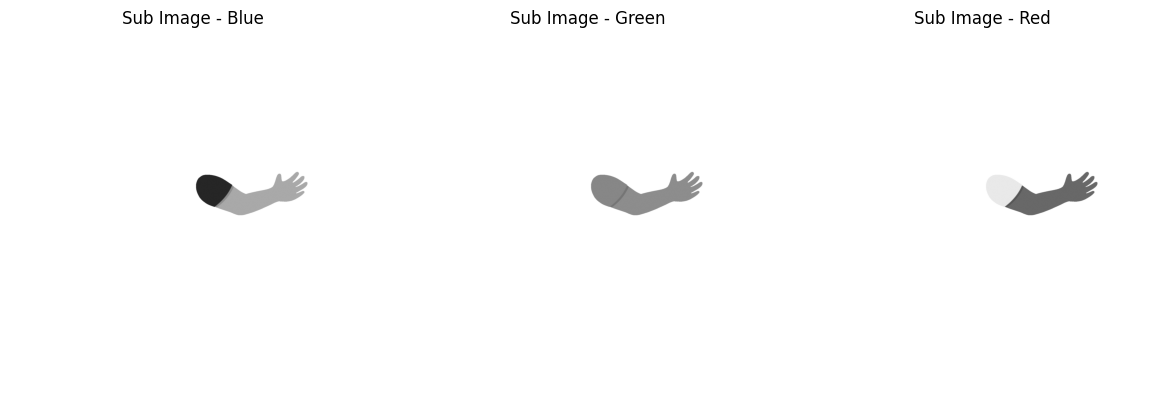

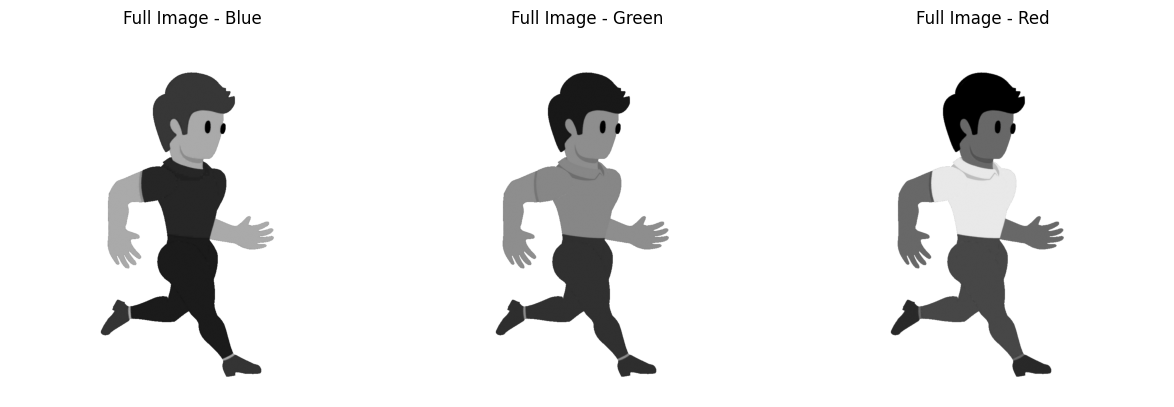

In [6]:

def plot_image_channels(channels, title_prefix="Channel"):
    color_names = ['Blue', 'Green', 'Red']
    plt.figure(figsize=(12, 4))
    for i, ch in enumerate(channels):
        plt.subplot(1, 3, i + 1)
        plt.imshow(ch, cmap='gray', vmin=0, vmax=255)  # fix intensity range
        plt.title(f"{title_prefix} - {color_names[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


plot_image_channels(sub_channels, title_prefix="Sub Image")
plot_image_channels(full_channels, title_prefix="Full Image")

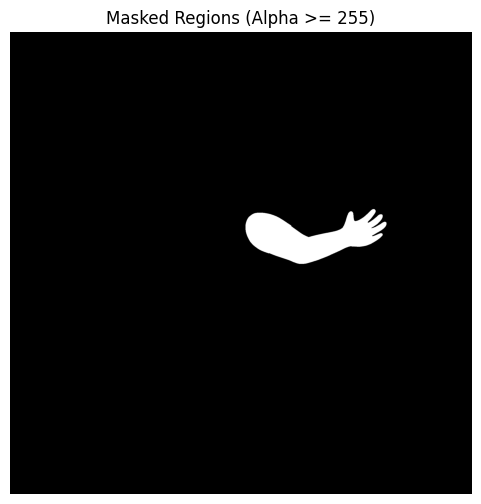

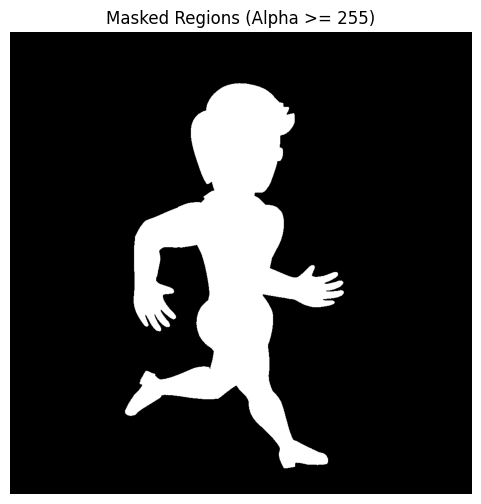

In [7]:
def get_alpha_mask(img, threshold=1):
    """
    Returns a binary mask (uint8) where alpha >= threshold is 255, else 0.
    """
    if img.shape[2] == 4:
        alpha = img[:, :, 3]
        mask = np.where(alpha >= threshold, 255, 0).astype(np.uint8)
        return mask
    else:
        print("Image has no alpha channel.")
        return None

def show_mask(mask, title="Alpha Mask"):
    if mask is not None:
        plt.figure(figsize=(6, 6))
        plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print("Mask is None.")

sub_mask = get_alpha_mask(sub_img, threshold=255)
full_mask = get_alpha_mask(full_img, threshold=255)

show_mask(sub_mask, title="Masked Regions (Alpha >= 255)")
show_mask(full_mask, title="Masked Regions (Alpha >= 255)")

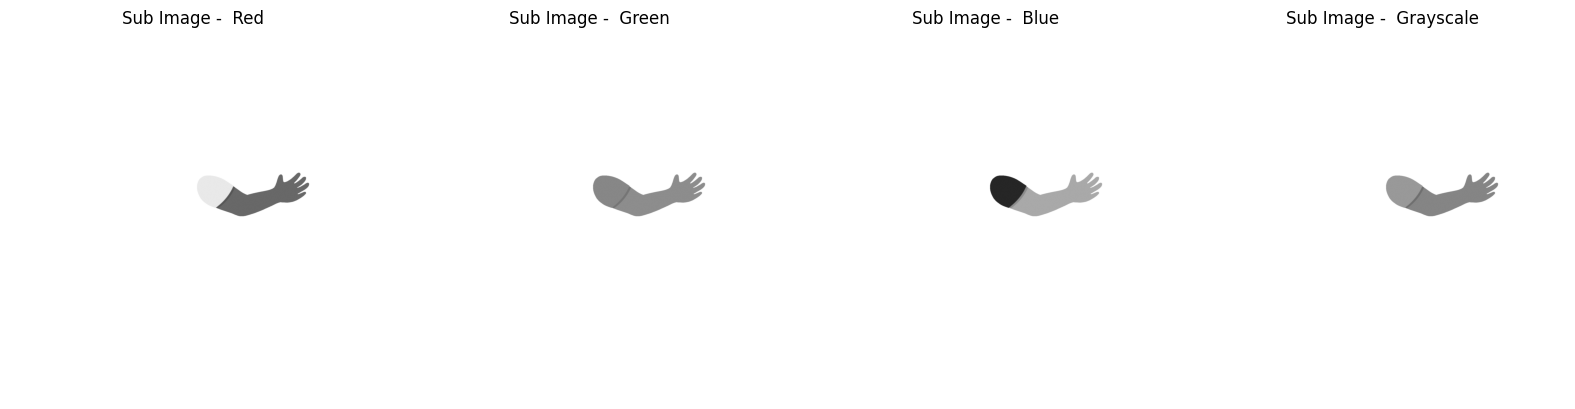

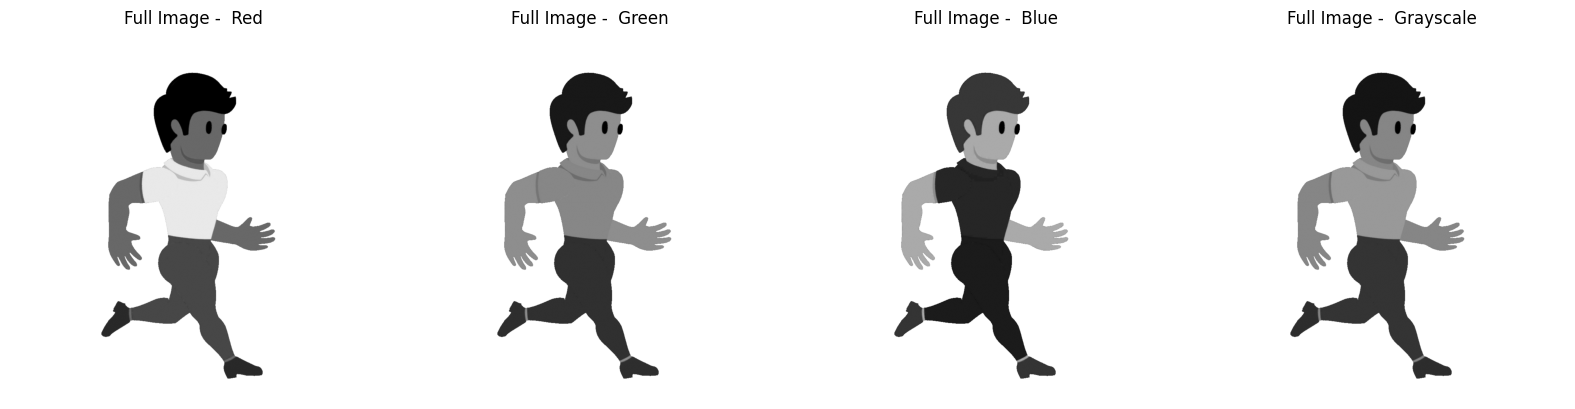

In [8]:
def get_rgb_and_gray(img):
    """
    Given a 3-channel (or 4-channel) image, returns a tuple:
    (R, G, B, Gray), each as single-channel images (uint8).
    """
    if img.shape[2] == 4:
        img = img[:, :, :3]  # Strip alpha if present

    b, g, r = cv2.split(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # OpenCV uses BGR order

    return [r, g, b, gray]

sub_channels = get_rgb_and_gray(sub_img_rgb)
full_channels = get_rgb_and_gray(full_img_rgb)

def plot_r_g_b_gray(channels, title_prefix=""):
    names = ['Red', 'Green', 'Blue', 'Grayscale']
    plt.figure(figsize=(16, 4))
    for i, (ch, name) in enumerate(zip(channels, names)):
        plt.subplot(1, 4, i + 1)
        plt.imshow(ch, cmap='gray', vmin=0, vmax=255)
        plt.title(f"{title_prefix} {name}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_r_g_b_gray(sub_channels, title_prefix="Sub Image - ")
plot_r_g_b_gray(full_channels, title_prefix="Full Image - ")


In [9]:
def sift_on_channels(sift, channels, masks=None):
    """
    Run SIFT on a list of single-channel images.
    Optionally provide masks (same shape as image).
    
    Returns: list of (keypoints, descriptors)
    """
    results = []
    for i, ch in enumerate(channels):
        mask = masks[i] if masks else None
        kp, des = sift.detectAndCompute(ch, mask)
        results.append((kp, des))
    return results


sift = cv2.SIFT_create()

sub_masks = [sub_mask] * 4
full_masks = [full_mask] * 4

sub_sift_results = sift_on_channels(sift, sub_channels, sub_masks)
full_sift_results = sift_on_channels(sift, full_channels, full_masks)

channel_names = ['Red', 'Green', 'Blue', 'Grayscale']

print("Sub-image:")
for i, (kp, des) in enumerate(sub_sift_results):
    print(f"{channel_names[i]} channel: {len(kp)} keypoints")

print("\nFull image:")
for i, (kp, des) in enumerate(full_sift_results):
    print(f"{channel_names[i]} channel: {len(kp)} keypoints")


Sub-image:
Red channel: 16 keypoints
Green channel: 18 keypoints
Blue channel: 20 keypoints
Grayscale channel: 18 keypoints

Full image:
Red channel: 162 keypoints
Green channel: 99 keypoints
Blue channel: 106 keypoints
Grayscale channel: 97 keypoints


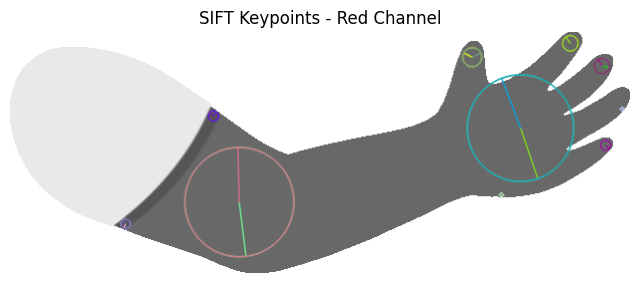

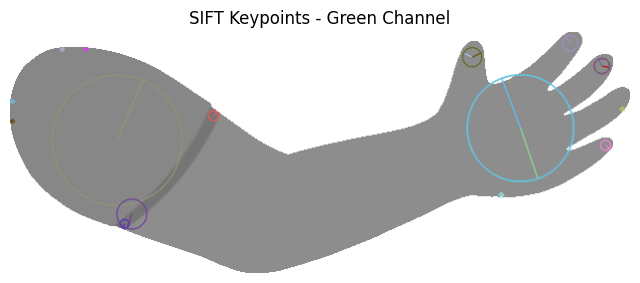

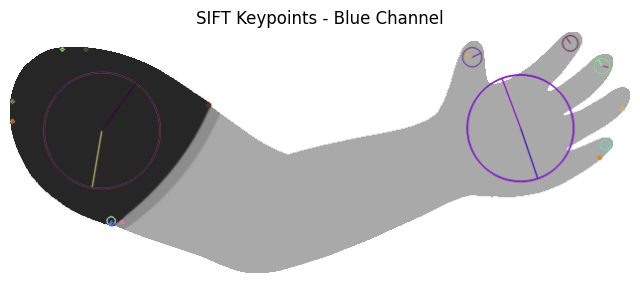

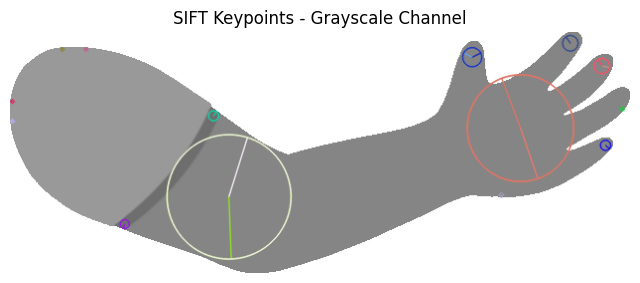

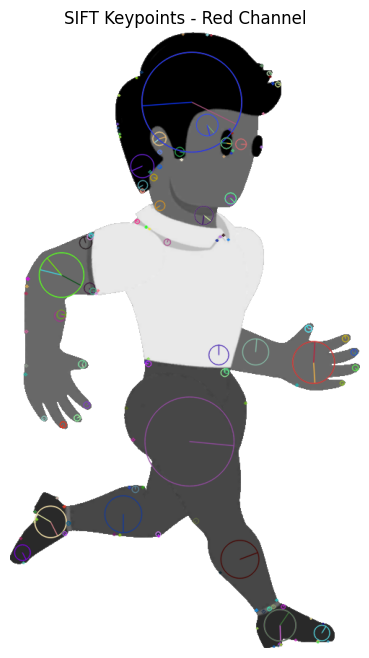

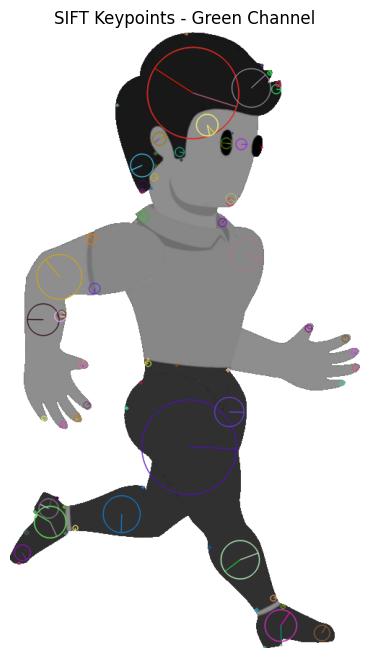

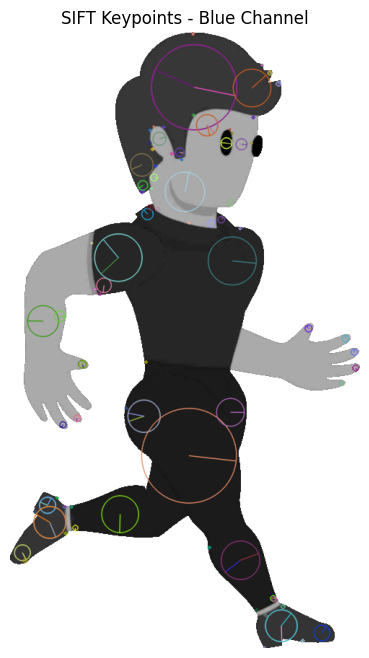

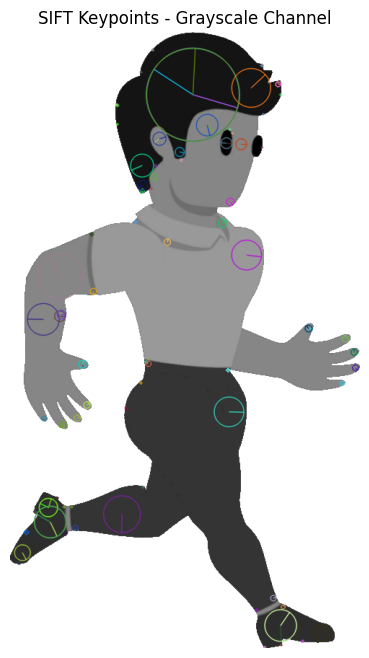

In [10]:
def visualize_keypoints_on_image(img, keypoints, title="Keypoints", binary_mask=None):
    """
    Displays keypoints on an image with optional cropping based on a binary mask.
    
    Parameters:
    - img: Input image (grayscale or BGR)
    - keypoints: List of cv2.KeyPoint
    - title: Title for the plot
    - binary_mask: Optional 2D mask (same size as image) for cropping
    """
    # Convert to 3-channel BGR if needed
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img_vis = img.copy()

    # === TEMPORARY CROP using binary mask ===
    if binary_mask is not None:
        mask = binary_mask > 0
        coords = np.argwhere(mask)
        if coords.size > 0:
            y0, x0 = coords.min(axis=0)
            y1, x1 = coords.max(axis=0) + 1
            img_vis = img_vis[y0:y1, x0:x1]

            # Adjust keypoints to cropped region
            new_keypoints = []
            for kp in keypoints:
                x, y = kp.pt
                if y0 <= y < y1 and x0 <= x < x1:
                    kp_new = cv2.KeyPoint(x - x0, y - y0, kp.size, kp.angle,
                                          kp.response, kp.octave, kp.class_id)
                    new_keypoints.append(kp_new)
            keypoints = new_keypoints

    # === Draw keypoints ===
    img_with_kp = cv2.drawKeypoints(
        img_vis,
        keypoints,
        None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    # Convert to RGB for matplotlib
    img_rgb = cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB)

    # Show with Matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()


for i in range(4):
    visualize_keypoints_on_image(
        sub_channels[i],
        sub_sift_results[i][0],  # keypoints
        title=f"SIFT Keypoints - {channel_names[i]} Channel",
        binary_mask=sub_mask
    )

for i in range(4):
    visualize_keypoints_on_image(
        full_channels[i],
        full_sift_results[i][0],  # keypoints
        title=f"SIFT Keypoints - {channel_names[i]} Channel",
        binary_mask=full_mask
    )

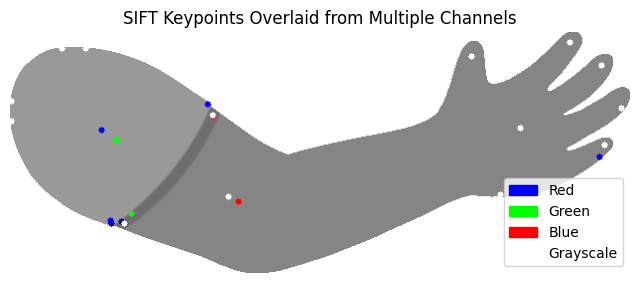

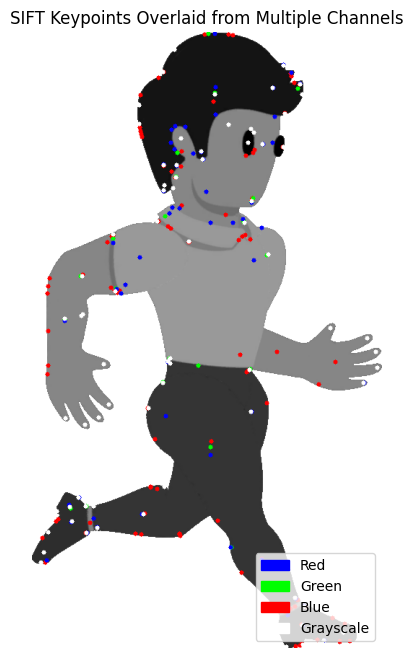

In [11]:
def overlay_keypoints_multi_channel(base_img, kp_lists, colors, channel_names, binary_mask=None):
    """
    Draws keypoints from multiple channels on a masked & cropped base image.
    
    Parameters:
    - base_img: BGR image (3 channels)
    - kp_lists: list of lists of cv2.KeyPoint
    - colors: list of BGR color tuples
    - channel_names: names for legend
    - binary_mask: Optional 2D binary mask (same height/width as base_img) for cropping
    """
    img = base_img.copy()

    # === TEMPORARY CROP using mask ===
    if binary_mask is not None:
        mask = binary_mask > 0
        coords = np.argwhere(mask)
        if coords.size > 0:
            y0, x0 = coords.min(axis=0)
            y1, x1 = coords.max(axis=0) + 1
            img = img[y0:y1, x0:x1]

            # Adjust keypoints to cropped region
            cropped_kp_lists = []
            for kp_list in kp_lists:
                new_kps = []
                for kp in kp_list:
                    x, y = kp.pt
                    if y0 <= y < y1 and x0 <= x < x1:
                        kp_new = cv2.KeyPoint(x - x0, y - y0, kp.size, kp.angle,
                                              kp.response, kp.octave, kp.class_id)
                        new_kps.append(kp_new)
                cropped_kp_lists.append(new_kps)
            kp_lists = cropped_kp_lists

    # === Draw keypoints ===
    overlay = img.copy()
    for kp_list, color in zip(kp_lists, colors):
        for kp in kp_list:
            x, y = map(int, kp.pt)
            cv2.circle(overlay, (x, y), radius=3, color=color, thickness=-1)

    # Convert to RGB for plotting
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(overlay_rgb)
    plt.title("SIFT Keypoints Overlaid from Multiple Channels")
    plt.axis('off')

    from matplotlib.patches import Patch
    legend_handles = [
        Patch(color=np.array(color)/255.0, label=name)
        for color, name in zip(colors, channel_names)
    ]
    plt.legend(handles=legend_handles, loc='lower right')
    plt.show()


# Base image for overlay (grayscale or one of the color channels converted to BGR)
sub_base = cv2.cvtColor(sub_channels[3], cv2.COLOR_GRAY2BGR)
full_base = cv2.cvtColor(full_channels[3], cv2.COLOR_GRAY2BGR)

# Get keypoints from sift_results
sub_kps = [sub_sift_results[i][0] for i in range(4)]
full_kps = [full_sift_results[i][0] for i in range(4)]

# Define BGR colors
colors = [(0, 0, 255),    # Red keypoints → blue dots (BGR)
          (0, 255, 0),    # Green → green dots
          (255, 0, 0),    # Blue → red dots
          (255, 255, 255) # Grayscale → white dots
         ]

overlay_keypoints_multi_channel(sub_base, sub_kps, colors, channel_names, sub_mask)
overlay_keypoints_multi_channel(full_base, full_kps, colors, channel_names, full_mask)


In [12]:
kp1 = sub_sift_results[3][0]
kp2 = full_sift_results[3][0]
des1 = sub_sift_results[3][1]
des2 = full_sift_results[3][1]

# Match descriptors using Lowe's ratio test
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=10)

#good_matches = []
#for m, n in matches:
#    if m.distance < 0.75 * n.distance:
#        good_matches.append((m.queryIdx, m.trainIdx))

# Get coordinates of matched keypoints
#src_pts = np.array([kp1[q].pt for q, _ in good_matches])  # sub-image points
#tgt_pts = np.array([kp2[t].pt for _, t in good_matches])  # full-image points

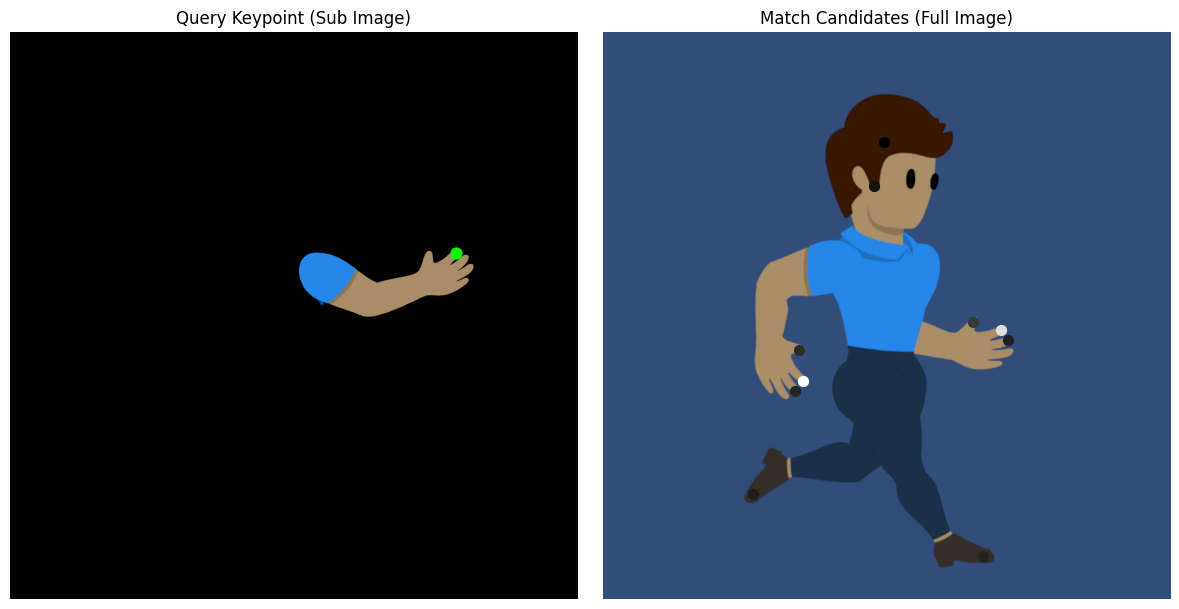

In [13]:
def plot_query_match_candidates(sub_img, full_img, query_kp, train_kps, distances, max_intensity=1.0):
    """
    Plots the query keypoint on sub_img and all candidate matches on full_img,
    where match distance is mapped to intensity.
    """
    # Normalize distances to [0, 1]
    distances = np.array(distances)
    if len(distances) > 1:
        norm_distances = (distances - distances.min()) / (distances.max() - distances.min() + 1e-6)
    else:
        norm_distances = np.zeros_like(distances)  # single match

    intensities = max_intensity * (1 - norm_distances)  # low distance = bright

    # Prepare images
    sub_rgb = cv2.cvtColor(sub_img, cv2.COLOR_BGR2RGB)
    full_rgb = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Left: Sub image with query point
    axs[0].imshow(sub_rgb)
    x, y = query_kp.pt
    axs[0].scatter([x], [y], c='lime', s=60)
    axs[0].set_title("Query Keypoint (Sub Image)")
    axs[0].axis('off')

    # Right: Full image with candidates colored by match quality
    axs[1].imshow(full_rgb)
    for kp, intensity in zip(train_kps, intensities):
        x, y = kp.pt
        axs[1].scatter([x], [y], c=[[intensity]*3], s=50)
    axs[1].set_title("Match Candidates (Full Image)")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

i = 13  # pick a query keypoint to visualize
match_list = matches[i]

query_kp = kp1[match_list[0].queryIdx]
train_kps = [kp2[m.trainIdx] for m in match_list]
distances = [m.distance for m in match_list]

plot_query_match_candidates(sub_img, full_img, query_kp, train_kps, distances)


In [14]:
import itertools
import math

def count_injective_mappings(kp1, kp2):
    M = len(kp1)
    N = len(kp2)
    print(f"kp1 len: {M}")
    print(f"kp1 len: {N}")
    if M > N:
        print("No valid injective mappings: more kp1 than kp2.")
        return 0
    num_mappings = math.perm(N, M)  # equivalent to N! / (N - M)!
    print(f"Expected number of mappings: {num_mappings}")
    return num_mappings

count_injective_mappings(kp1, kp2)


kp1 len: 18
kp1 len: 97
Expected number of mappings: 107523811024919600172804398776320000


107523811024919600172804398776320000

In [15]:
# kp1, des1, kp2, des2 are given

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

matches_with_ratio = []
for m, n in matches:
    ratio = m.distance / n.distance
    matches_with_ratio.append((m, ratio))

matches_with_ratio.sort(key=lambda x: x[1])

selected_matches = []
used_kp2_indices = set()

for m, ratio in matches_with_ratio:
    if m.trainIdx not in used_kp2_indices:
        selected_matches.append(m)
        used_kp2_indices.add(m.trainIdx)
    if len(selected_matches) == 3:
        break

if len(selected_matches) < 3:
    raise ValueError("Could not find 3 unique matches")

pts1 = np.float32([kp1[m.queryIdx].pt for m in selected_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in selected_matches])

# Estimate similarity transform using estimateAffinePartial2D
M, inliers = cv2.estimateAffinePartial2D(pts1, pts2, method=cv2.LMEDS)

print("Similarity transform matrix:\n", M)


Similarity transform matrix:
 [[-4.21138403e-01 -3.68920336e-01  1.21683166e+03]
 [ 3.68920336e-01 -4.21138403e-01  3.77560463e+02]]


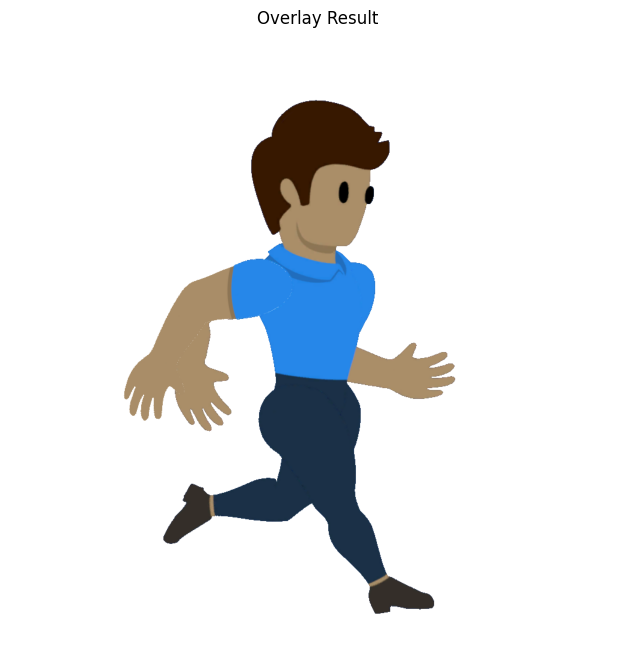

: 

In [ ]:
img_src = sub_img_rgb
img_dst = full_img_rgb
mask_src = sub_mask

# Step 1: Warp source image and mask to the target image size
height, width = img_dst.shape[:2]

warped_src = cv2.warpAffine(img_src, M, (width, height), flags=cv2.INTER_LINEAR)
warped_mask = cv2.warpAffine(mask_src, M, (width, height), flags=cv2.INTER_NEAREST)

# Step 2: Create boolean mask (True where we want to replace)
if len(warped_mask.shape) == 3:  # If it's 3-channel, reduce to single channel
    mask = (warped_mask[:, :, 0] > 0)
else:
    mask = (warped_mask > 0)

# Step 3: Replace pixels in destination where mask is True
output = img_dst.copy()
output[mask] = warped_src[mask]

plt.figure(figsize=(8, 8))
plt.imshow(output)
plt.axis('off')
plt.title("Overlay Result")
plt.show()
